# IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [7]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [8]:
# Especificar el directorio del conjunto de entrenamiento
XRay_Directory = "./x_ray_directory/Dataset"

In [9]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['0', '1', '3', '2']

In [10]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [11]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "training")

Found 428 images belonging to 4 classes.


In [12]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "validation")

Found 104 images belonging to 4 classes.


In [13]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [14]:
train_images.shape

(40, 256, 256, 3)

In [15]:
train_labels.shape

(40, 4)

In [17]:
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]],

In [18]:
# Traducción de cada Etiqueta
label_names = {0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia Virica', 3: 'Pneumonia Bacteriana'}

# VISUALIZACIÓN DEL DATASET

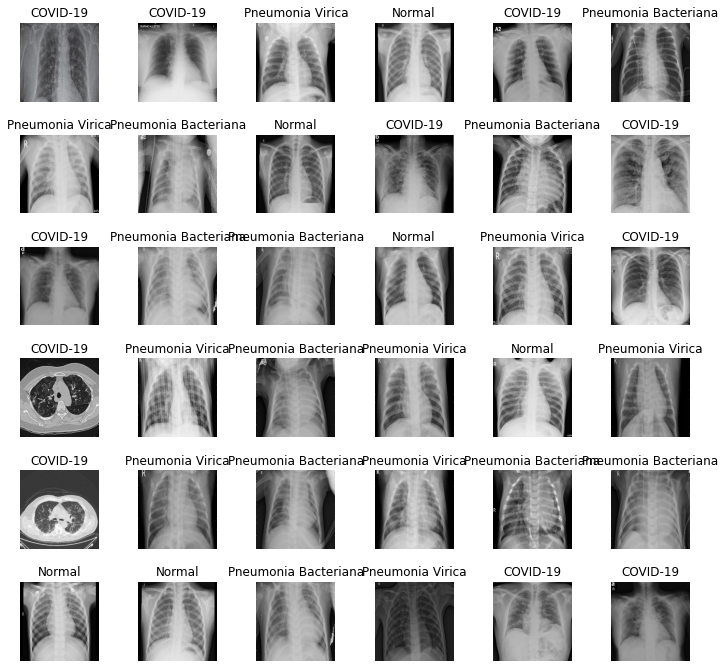

In [19]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS

In [22]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [23]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
# Congelar el modelo hasta las últimas etapas - 4 y llevar a cabo un re entrenamiento -5 
for layer in basemodel.layers[:-10]:
    layer.trainable = False

# TAREA #7: CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING

In [25]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics = ["accuracy"])

In [27]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [28]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [29]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25, 
                              validation_data = val_generator, validation_steps = val_generator.n // 4,
                              callbacks = [checkpointer, earlystopping])

Epoch 1/25
106/107 [============================>.] - ETA: 6s - loss: 0.9674 - accuracy: 0.6203 
Epoch 00001: val_loss improved from inf to 1.98811, saving model to weights.hdf5
107/107 [==============================] - 696s 7s/step - loss: 0.9771 - accuracy: 0.6168 - val_loss: 1.9881 - val_accuracy: 0.2500
Epoch 2/25
106/107 [============================>.] - ETA: 6s - loss: 0.4735 - accuracy: 0.8137 
Epoch 00002: val_loss did not improve from 1.98811
107/107 [==============================] - 730s 7s/step - loss: 0.4701 - accuracy: 0.8154 - val_loss: 3.8327 - val_accuracy: 0.2500
Epoch 3/25
106/107 [============================>.] - ETA: 6s - loss: 0.3519 - accuracy: 0.9057 
Epoch 00003: val_loss did not improve from 1.98811
107/107 [==============================] - 759s 7s/step - loss: 0.3546 - accuracy: 0.9019 - val_loss: 2.7093 - val_accuracy: 0.2500
Epoch 4/25
106/107 [============================>.] - ETA: 6s - loss: 0.2210 - accuracy: 0.9222 
Epoch 00004: val_loss did not imp

# TAREA #8: EVALUAR EL MODELO DE DEEP LEARNING ENTRENADO

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

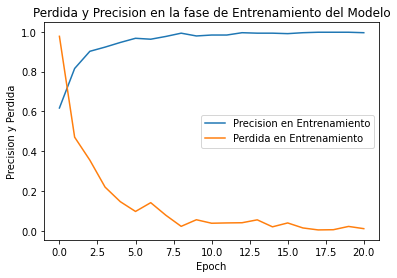

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

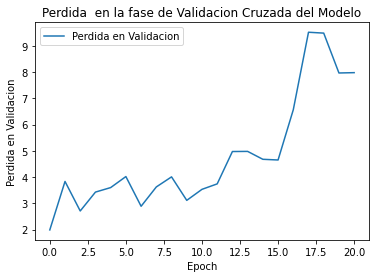

In [33]:
plt.plot(history.history['val_loss'])

plt.title("Perdida  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Perdida en Validacion")
plt.legend(["Perdida en Validacion"])

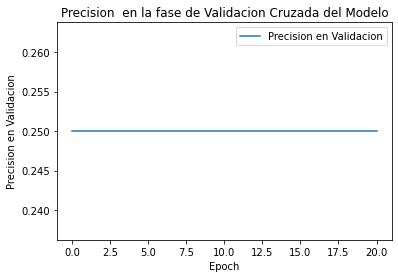

In [34]:
plt.plot(history.history['val_accuracy'])

plt.title("Precision  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision en Validacion")
plt.legend(["Precision en Validacion"])

In [35]:
test_directory = "./x_ray_directory/Test"

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode="categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)
test_directory = "/content/drive/My Drive/Curso de Data Science para Empresas/4. Operations Department/Test"
print("Precision en la fase de Test : {}".format(evaluate[1]))

Found 40 images belonging to 4 classes.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

In [ ]:
len(original)

In [ ]:
score = accuracy_score(original, prediction)
print("Eficacia de la prediccion {}".format(score))

In [ ]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       1.00      0.20      0.33        10
           2       1.00      0.30      0.46        10
           3       0.34      1.00      0.51        10

    accuracy                           0.53        40
   macro avg       0.84      0.53      0.51        40
weighted avg       0.84      0.53      0.51        40



Text(0.5, 1.0, 'Matriz de Confusion')

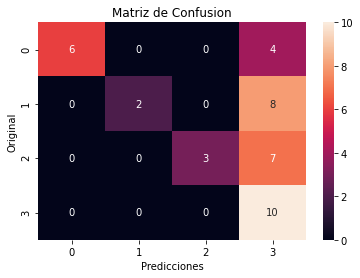

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")

# BUEN TRABAJO! PUEDES ESTAR ORGULLOSO DE TUS NUEVAS HABILIDADES ADQUIRIDAS
